# Simulation and Performance Evaluation - Homework 3

### University of Trento - A.Y. 2019 / 2020

Lotito Quintino Francesco - 215032

Zanella Davide - 211463

---

**Important:** we delivered two files, a .ipynb file (jupyter notebook) and a .html file (export of the notebook), if the .ipynb file is run we expect the datasets to be in the same directory of this notebook in order to be read as input.

## Exercise 1

The first thing to do is to define the function described in the problem statement:
$f(x) = \frac{1}{A} \mid \frac{sin(\pi x)}{\pi x} \mid $



In [1]:
from math import sin, pi
import random as rnd

In [2]:
def f(x):
    A = 1.8988
    if x == 0:
        return 1/A
    return 1/A * abs(sin(pi * x) / (pi * x))

The following function implements the rejection sampling method for an arbitrary number of times, sampling from the previous funcion $f(x)$.

The bounds of the rectangle where we are sampling from are $[-6, 6]$ for the $x$ axis and $[0, 0.55]$ for the $y$ one. The first interval is defined by the problem statement, while the second one is obtained from the sine boundaries $[-1, 1]$ limited by the absolute value and divided by A. So more or less $[0, 0.55]$.

In [3]:
def rejection_sampling(n):
    points = []
    for i in range(n):
        U1 = rnd.uniform(-6, 6)
        U2 = rnd.uniform(0, 0.55)
    
        if U2 < f(U1):
            points.append(U1)
    return points

Using the $f(x)$ function previously defined, we can now plot the function in the interval where it is defined and see how it behaves.

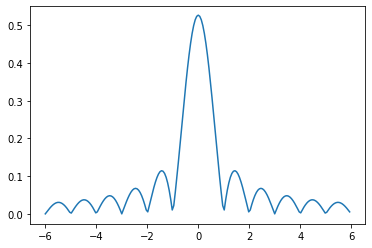

In [46]:
%matplotlib inline
from matplotlib import pyplot as plt

steps = 200
x = [ -6 + (12/steps)*i for i in range(steps)]
y = [f(i) for i in x]

plt.plot(x, y)
plt.ylim(top=0.55)
plt.show()

The following is a useful function that will be used nextly to plot easily our empirical probability distribution functions.

In the `histogram` function of `matplotlib` the flag density is set to `True` in order to normaliza the data and obtain an integral of the area equal to $1$ and respect the problem specification: $\int_{-6}^{6} f(t) dt = 1$.

In [5]:
from matplotlib import pyplot as plt

def plot_point(x):
    steps = 200
    X = [ -6 + (12/steps)*i for i in range(steps)]
    y = [f(i) for i in X]
    plt.plot(X, y, color='r')
    plt.ylim(top=0.55)
    
    plt.hist(x, bins=200, density=True)
    plt.ylim(top=0.55)
    plt.show()

With number of sampling equal to $10^5$, we obtain a worse plot with respect to the previous one. All the peaks are less defined and smoothed with respect to the theoretical function.

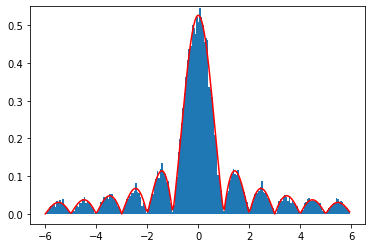

In [6]:
points = rejection_sampling(100000)
plot_point(points)

Increasing the number of samples to $10^8$ rises sensibly the computation time but gives some enhancements.

The obtained plot is more smoothed compared to the previous empirical one, and the peaks are better defined than before.

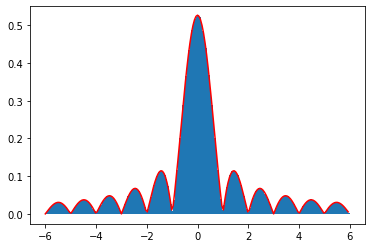

In [7]:
points = rejection_sampling(10000000)
plot_point(points)

## Exercise 2

Let's start by defining a class which will represent a state of the Markov chain. An instance of this class will implement the transition probability vector of a given state and a counter; this counter is used to count the number of time the state is visited. We also defined the function `get_next()` to generate the next state to visit, which implements random variate generation by CDF inversion (discrete case) using the given transition probability vector.

In [8]:
class State:
    def __init__(self, transition):
        self.counter = 0
        self.set_transition(transition)
    
    def get_counter(self):
        return self.counter
    
    def visit(self):
        self.counter += 1
    
    def set_transition(self, transition):
        self.adj = transition
        self.cdf = [transition[0]]
        for i in range(1, len(transition)):
            self.cdf.append(self.cdf[-1] + transition[i])
        
    def get_next(self):
        import random
        u = random.random()
        for i in range(len(self.cdf)):
            if u < self.cdf[i]:
                return i + 1

In the next step, we implement what is asked in point 1 and 2 of the exercise. We define the Markov chain, set up its transition matrix and find the average fractions of time that the Markov chain spends in each of the four states. 

When it comes to the plotting phase, we log the stationary distribution and throughput (the former will be useful in the next steps of the exercise) every 100 iterations.

In [9]:
import random

def run(N_iter):
    results = {}
    results[1] = []
    results[2] = []
    results[3] = []
    results[4] = []
    
    s2t = {1:1.5, 2:1, 3:0.250, 4: 0.05}
    
    thr = []
    
    states = {}
    states[1] = State([0.75, 0.25, 0, 0])
    states[2] = State([0.25, 0.50, 0.25, 0])
    states[3] = State([0, 0.40, 0.40, 0.20])
    states[4] = State([0, 0, 0.25, 0.75])
    
    state_id = random.randint(1, 4)
    for i in range(1, N_iter):
        states[state_id].visit()
        state_id = states[state_id].get_next()
        
        if i % 100 == 0:
            for j in range(1, 5):
                results[j].append(states[j].get_counter() / i)
            thr.append(s2t[state_id])
    
    print("Empirical stationary probability distribution")
    for i in range(1, 5):
        print("State {}: {:.4f}".format(i, states[i].get_counter() / N_iter))
    
    return results, thr

So now we can compute the empirical stationary probability distribution from our simulation, which is comparable to the theoretical one.

In [10]:
results, thr = run(1000000)

Empirical stationary probability distribution
State 1: 0.3200
State 2: 0.3216
State 3: 0.2003
State 4: 0.1581


And we can plot the fractions computed in the previous point as a function of the number of steps.

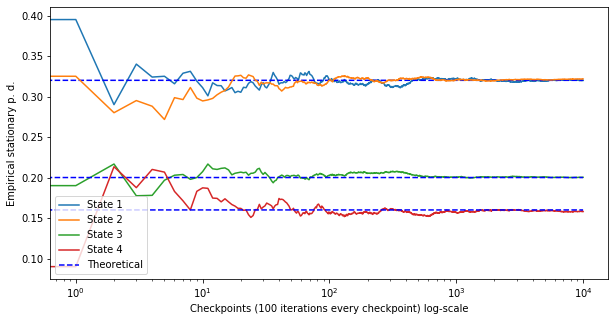

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(range(len(results[1])), results[1], label="State 1")
ax.plot(range(len(results[1])), [0.32 for _ in range(len(results[1]))], 'b--')
ax.plot(range(len(results[2])), results[2], label="State 2")
ax.plot(range(len(results[3])), results[3], label="State 3")
ax.plot(range(len(results[1])), [0.20 for _ in range(len(results[1]))], 'b--')
ax.plot(range(len(results[4])), results[4], label="State 4")
ax.plot(range(len(results[1])), [0.16 for _ in range(len(results[1]))], 'b--', label="Theoretical")
ax.legend()
ax.set_xscale('log')
plt.xlabel("Checkpoints (100 iterations every checkpoint) log-scale")
plt.ylabel("Empirical stationary p. d.")
plt.show()

The next step is the communication system modeling. We use the data about the throughput mentioned in the previus steps. Every state of the Markov chain is associated with a given throughput. We saved the values of the throughput at every checkpoint. With this data, we can compute the mean and the confidence interval of the mean using the functions from Homework 1.

In [12]:
from math import sqrt

def compute_mean(values):
    tot = 0
    for i in values:
        tot += i
    return tot / len(values)

def compute_std_dev(values):
    mean = compute_mean(values)
    tot = 0
    for i in values:
        tot += (i - mean) ** 2
    return sqrt(tot / len(values))

def mean_interval(data, gamma):
    eta = None
    if gamma == 0.95:
        eta = 1.960
    elif gamma == 0.99:
        eta = 2.576
    else:
        # in these excercises we are only interested in 95% and 99% confidence
        pass
    mean = compute_mean(data)
    std_dev = compute_std_dev(data)
    incr = eta * std_dev / sqrt(len(data))
    return mean - incr, mean + incr

In [13]:
print("Average throughput: {:.4f} Gbit/s".format(compute_mean(thr)))
print("C.I. 95% [{:.4f} Gbit/s, {:.4f} Gbit/s]".format(mean_interval(thr, 0.95)[0], mean_interval(thr, 0.95)[1]))

Average throughput: 0.8673 Gbit/s
C.I. 95% [0.8563 Gbit/s, 0.8783 Gbit/s]


Now we can plot the average throughput and the corresponding confidence intervals against the number of checkpoints.

In [14]:
a_thr = []
l_thr = []
h_thr = []

for i in range(len(thr)):
    values = thr[:i+1]
    a_thr.append(compute_mean(values))
    l, h = mean_interval(values, 0.95)
    l_thr.append(l)
    h_thr.append(h)

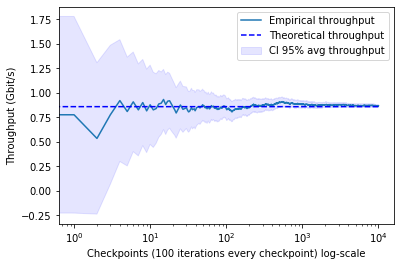

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(len(a_thr)), a_thr, label="Empirical throughput")
ax.fill_between(range(len(a_thr)), l_thr, h_thr, color='b', alpha=.1, label="CI 95% avg throughput")
ax.plot(range(len(a_thr)), [0.32 * 1.5 + 0.32 * 1 + 0.20 * 0.250 + 0.16 * 0.050 for _ in range(len(a_thr))], 'b--', label="Theoretical throughput")
ax.legend()
ax.set_xscale('log')
plt.xlabel("Checkpoints (100 iterations every checkpoint) log-scale")
plt.ylabel("Throughput (Gbit/s)")
plt.show()

We have that 
$$P(\text{throughput} = 1.5 \text{Gbit/s}) = \pi_1 = 0.32$$
$$P(\text{throughput} = 1 \text{Gbit/s}) = \pi_2 = 0.36$$
$$P(\text{throughput} = 0.250 \text{Gbit/s}) = \pi_3 = 0.20$$
$$P(\text{throughput} = 0.050 \text{Gbit/s}) = \pi_4 = 0.16$$ 

where $\pi_i$ is the stationary probability of State $i$.

We can compute the expected value of the throughput:

$$\mathbf{E}[\text{throughput}] = 0.32 * 1.5 + 0.32 * 1 + 0.20 * 0.250 + 0.16 * 0.050 = 0.86 \text{Gbit/s}$$

We expected the empirical throughput to converge to the theoretical one, and this is what happened.

## Exercise 3

Firstly, we define a function to compute a Monte-Carlo simulation, receiving as parameters $r$, $N$, $p$ and $n\_iter$, that is the number of the iteration done in the simulation.

Basically, for every iteration it's computed the probability of the links connecting every stage, then for every node in the current stage, it's randomly decided if it receives correctly the packet or not concerning the computed probability. In every iteration, we store the number of nodes that receive correctly the packet for every stage. We count even if after every iteration the $D$ node receives correctly at least a packet.

The result of the function is two lists. The first one contains a series of $0$ and $1$ that states if the packet is received correctly by the $D$ node. The second list contains for every stage the number of nodes that received correctly the packet.

In [16]:
import random as rnd

def MC_simulation(r, n, p, n_iter):
    n_received = 0
    tot_succ_nodes = []
    for _ in range(n_iter):
        n_succ = 1
        for ns in range(r):
            prob_loss = p**n_succ
            n_succ = 0
            for node in range(n):
                v = rnd.random()
                if v > prob_loss:
                    n_succ += 1
            tot_succ_nodes.append(n_succ)

        if n_succ > 0:
            n_received += 1
    return [0] * n_received + [1] * (n_iter-n_received), tot_succ_nodes

Now, we define a simple function to compute the mean of a list.

In [17]:
def compute_mean(values):
    tot = 0
    for i in values:
        tot += i
    return tot / len(values)

The previous mean function can be now used to compute the probability that a packet transmitted by the source $S$ fails to reach the destination $D$ from the Monte-Carlo simulation with parameters:
$r = 2$, $N = 2$, $p = 0.2$ and $n\_iter = 1000$.

In [18]:
compute_mean(MC_simulation(2, 2, 0.2, 1000)[0])

0.053

Now, we compute the probability as before but changing the parameters as follows:
$r = 5$, $N = 10$, $p = 0.2$ and $n\_iter = 1000$.

In [19]:
compute_mean(MC_simulation(5, 10, 0.2, 1000)[0])

0.0

The two following functions are used to compute the standard deviation and the mean interval of some data.

In [20]:
def compute_std_dev(values):
    mean = compute_mean(values)
    tot = 0
    for i in values:
        tot += (i - mean) ** 2
    return math.sqrt(tot / len(values))

In [21]:
import math

def mean_interval(data, gamma):
    eta = None
    if gamma == 0.95:
        eta = 1.960
    elif gamma == 0.99:
        eta = 2.576
    else:
        # in these excercises we are only interested in 95% and 99% confidence
        pass
    mean = compute_mean(data)
    std_dev = compute_std_dev(data)
    incr = eta * std_dev / math.sqrt(len(data))
    return mean - incr, mean + incr

Now, we define a function to do a Monte-Carlo simulation, using the previousy defined function, for $100$ different link error probabilities. For each simulation's result it computes the 95% confidence interval and plot all the results. If the specific parameters are passed, the function plot even the theoretical function that describes the probability of having errors at node $D$ with respect to the error link probability.

In [22]:
from matplotlib import pyplot as plt

def plot_MC_simulation(r, n, theory=None, theory_col=1):
    steps = 100
    probs = [(1/steps)*i for i in range(steps)]

    results = []
    lower = []
    upper = []

    for p in probs:
        vals = MC_simulation(r, n, p, 1000)[0]
        results.append(compute_mean(vals))
        low, up = mean_interval(vals, 0.95)
        lower.append(low)
        upper.append(up)


    plt.plot(probs, results, label='Simulated error probability')
    plt.fill_between(probs, lower, upper, color='b', alpha=.1, label="CI 95% avg throughput")
    #plt.plot(probs, lower, c='r', label='Bounds C.I. 95%')
    #plt.plot(probs, upper, c='r')
    plt.title('Monte carlo simulation - r: {} N: {}'.format(r, n))
    plt.xlabel('Link prob of error')
    plt.ylabel('Prob of error at D')
    
    if theory != None:
        plt.plot(theory[0], theory[theory_col], c='g', label='Theoretical error probability')
    
    plt.legend()
    plt.show()

Executing the previous function with $r = 2$ and $N = 2$, gives the result below.

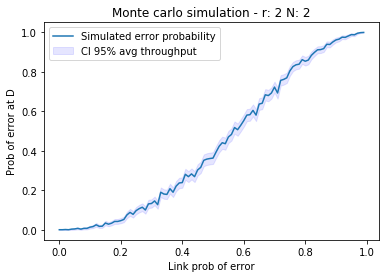

In [23]:
plot_MC_simulation(2, 2)

Now, we are asked to do the same for $r = 5$ and $N = 10$.

The difference between the two plots is evident. The previous one is pretty linear: at the increasing of the link error probability, it increases more or less in the same way even the probability of an error at node $D$.
While, in the following plot, until $0.6$ for the link error probability, the probability of an error at $D$ is very close to zero. Only after $0.6$ the error probability at $D$ increases fastly.

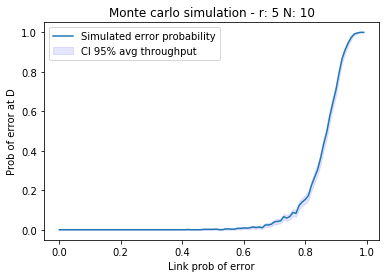

In [24]:
plot_MC_simulation(5, 10)

Now, we need to load the dataset of the theoretical distribution.

In [25]:
def load():
    file = open("theory_ex3.csv", "r")
    values = [[float(i) for i in x.split(',') ] for x in file.readlines()]
    new_val = [
        [i[0] for i in values],
        [i[1] for i in values],
        [i[2] for i in values]
    ]
    return new_val

In [26]:
theory = load()

Using the previous function we can plot our Monte-Carlo simulation and on the same graph the theoretical distribution loaded from the csv. Both for the two configuration parameters of $r$ and $N$.

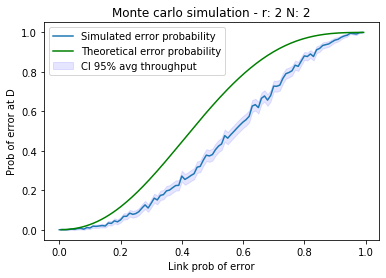

In [27]:
plot_MC_simulation(2, 2, theory, 1)

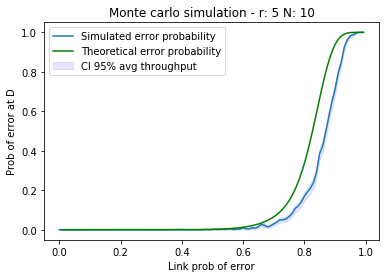

In [28]:
plot_MC_simulation(5, 10, theory, 2)

In both the previous plots, the theoretical error probabilities behave better than our simulated ones, especially for the one with $r = 2$ and $N = 2$.

The following consideration is intuitively correct, but now our plots confirm it: with more nodes per network stage we can obtain a more robust system. The number of stages doesn't seem to impact negatively the resulting probability of error at $D$. Anyway, we can suppose that with an $r$ value too higher than $N$, the final curve would be similar to a logarithmic one, reaching fastly the value 1.

The following is a modificated version of the previous one that plots the average number of nodes per stage of each Monte-Carlo simulation.

In [29]:
from matplotlib import pyplot as plt

def plot_avg_succ_nodes(r, n):
    steps = 100
    probs = [(1/steps)*i for i in range(steps)]
    
    succ_nodes = []
    lower = []
    upper = []
    values = []

    for p in probs:
        vals, nodes = MC_simulation(r, n, p, 1000)
        low, up = mean_interval(nodes, 0.95)
        lower.append(low)
        upper.append(up)
        
        succ_nodes.append(compute_mean(nodes))
        values.append(compute_mean(vals))


    plt.plot(values, succ_nodes, label='Avg number of succ nodes per stage')
    plt.fill_between(values, lower, upper, color='b', alpha=.1, label="CI 95% avg throughput")

    #plt.plot(values, lower, c='r', label='Bounds C.I. 95%')
    #plt.plot(values, upper, c='r')
    plt.title('Monte carlo simulation - r: {} N: {}'.format(r, n))
    plt.xlabel('Prob of error at D')
    plt.ylabel('Avg number of succ nodes per stage')
    
    
    plt.legend()
    plt.show()

Using the previous function we can now plot the average number of nodes per stage that successfully received the packet in each simulation.

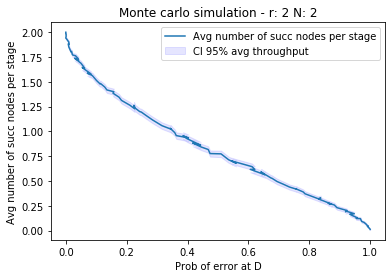

In [30]:
plot_avg_succ_nodes(2, 2)

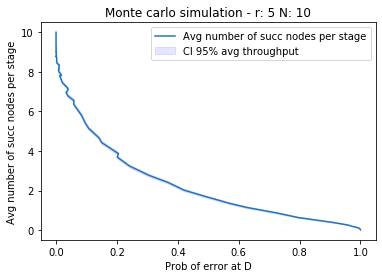

In [31]:
plot_avg_succ_nodes(5, 10)

The plots above clearly show the relationship between the average number of successful nodes per stage and the probability of error at $D$. With the decreasing of the number of successful nodes, it increases the probability of error at the destination $D$. With a high number of nodes per stage, we have a robust system and the curve reaches the 1 value on the x-axis slowly.

## Exercise 4

First of all here we define some utility functions. `gen_i()` and `gen_j()` generate the position of Node $i$ and $j$, `gen_p()` implements cdf inversion to generate an exponential random variate with average $1$, `d()` computes the Euclidean distance of two nodes $x, y$, `snr()` implement Equation $2$ from Exercise $4$.

In [32]:
import random, math

In [33]:
def gen_i(A=0, B=20, C=0, D=60):
    return (random.uniform(A, B), random.uniform(C, D))

def gen_j(A=60, B=80, C=0, D=60):
    return (random.uniform(60, 80), random.uniform(0, 60))

def gen_p():
    def cdf_inv(x, a):
        return - math.log(1 - x) / a
    y = random.random()
    return cdf_inv(y, 1)

def d(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def snr(p, a, b):
    k = 2
    P_T = 5
    P_N = 3.2 * 10**(-5)
    return p * P_T * (d(a,b)**(-k)) / P_N

The function `compute_prob` implements all the steps required to solve Task $1$.

In [34]:
def compute_prob(alpha, lim1, lim2):
    tot = 0
    ok = 0

    for iter_ij in range(lim1):
        i = gen_i()
        j = gen_j()
        for iter_p in range(lim2):
            p = gen_p()
            if snr(p, i, j) < alpha:
                ok += 1
            tot += 1
    return ok / tot

Here we report $P(\text{SNR} < \theta = 10)$

In [35]:
print("p = {:.4f}".format(compute_prob(10, 1000, 50)))

p = 0.2364


Then we are asked to plot the variation of $p$ vs $\theta$, where $\theta \in [1, 320]$.

In [36]:
x = []
y = []
for i in range(1, 321):
    x.append(i)
    y.append(compute_prob(i, 1000, 50))

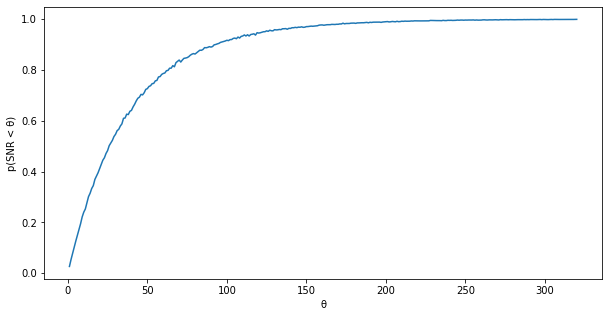

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel("θ")
plt.ylabel("p(SNR < θ)")
plt.show()

Now let's focus on Task $2$.

First of all, let's consider the number of realizations, both of fading and of the node positions, and see how $P(\text{SNR} < \theta = 10)$ changes. 

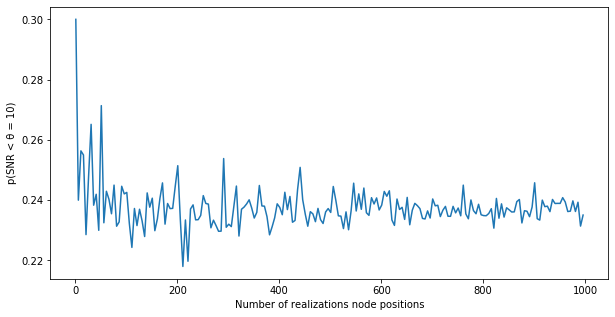

In [38]:
x = []
y = []
for i in range(1, 1000, 5):
    x.append(i)
    y.append(compute_prob(10, i, 50))
    
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel("Number of realizations node positions")
plt.ylabel("p(SNR < θ = 10)")
plt.show()

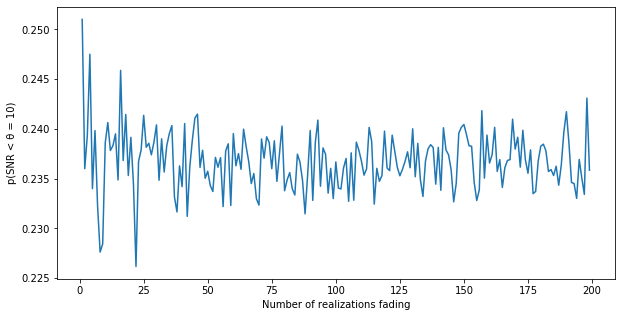

In [39]:
x = []
y = []
for i in range(1, 200, 1):
    x.append(i)
    y.append(compute_prob(10, 1000, i))
    
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel("Number of realizations fading")
plt.ylabel("p(SNR < θ = 10)")
plt.show()

It is trivial to see that in both cases the more the number of realizations the more stable the result gets. We can see that we require less number of realizations of the fading variable to make the result more or less stable, while we need more realizations of the positions to make the result stable. For the first plot we can notice a kind of stability after realization 600, while in the seconds the spikes are not that large, after 50 it seems we don't get a high improvement with the increasing of the number of realizations.

Now let's consider different areas.

In [40]:
def compute_prob(alpha, A, B, C, D, A1, B1, C1, D1):
    tot = 0
    ok = 0
    lim1 = 1000
    lim2 = 50

    for iter_ij in range(lim1):
        i = gen_i(A, B, C, D)
        j = gen_j(A1, B1, C1, D1)
        for iter_p in range(lim2):
            p = gen_p()
            if snr(p, i, j) < alpha:
                ok += 1
            tot += 1
    return ok / tot

In [41]:
x1 = []
y1 = []
for i in range(1, 321):
    x1.append(i)
    y1.append(compute_prob(i, 0, 0, 5, 5, 20, 20, 30, 30))

In [42]:
x2 = []
y2 = []
for i in range(1, 321):
    x2.append(i)
    y2.append(compute_prob(i, -80, -60, -60, 0, 160, 100, 180, 160))

In [43]:
x3 = []
y3 = []
for i in range(1, 321):
    x3.append(i)
    y3.append(compute_prob(i, 0, 0, 20, 60, 60, 0, 80, 60))

In [44]:
x4 = []
y4 = []
for i in range(1, 321):
    x4.append(i)
    y4.append(compute_prob(i, 0, 20, 40, 40, 0, 0, 20, 20))

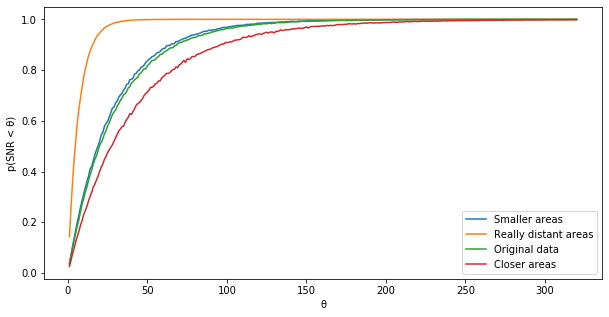

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(x1, y1, label="Smaller areas")
plt.plot(x2, y2, label="Really distant areas")
plt.plot(x3, y3, label="Original data")
plt.plot(x4, y4, label="Closer areas")
plt.xlabel("θ")
plt.ylabel("p(SNR < θ)")
plt.legend()
plt.show()

We plot the results of different experiments with different areas, we are able to notice that the distance beetween the two areas of sampling cause an increasing in the steepness of the resulting curve.